# Signed Networks - Creative Extension

The subject of this work will be to try to further extend with new ideas the research of the paper "Signed Networks in Social Media" from Jure Leskovec, Daniel Huttenlocher and Jon Kleinberg.

Authors paper: https://cs.stanford.edu/people/jure/pubs/triads-chi10.pdf <br>
Datasets: https://snap.stanford.edu/data/index.html

This notebook is organised as follow:
- [Introduction](#Introduction)
- [Data parsing](#Data_parsing)
- [Average Weight Prediction - Local](#AWP)
- [Triad type prediction - Global](#TTP)
- [Conclusion](#Conclusion)

## Introduction<a id='Introduction'></a>
This creative extension will try to assess the different effects between a local and a global prediction of weighted edges in a signed network. A local prediciton would consist in predicting an edge weight by looking at its proper conditions, for example its neighbors. A global prediction in our sense would be an edge weight prediction based on the overall structure of the signed network. So this extension will contain two parts. The first part's purpose is to build an algorithm that is able to predict the weight of edges locally. We will see that this research made us discover some interesting properties that we will further elaborate. The second part will consist of implementing an aglorithm which tries to predict an edge weight based on the overall triadic structure of the network. Both algorithms are made such that, in the end, their results can be comparable even if one of them is for local and the other for global. So, we will finally compare both techniques.

## Data Parsing <a id='Data_parsing'></a>
For our extension, we will use the same datasets than the ones in the paper: [Epinions](https://snap.stanford.edu/data/soc-sign-epinions.html), [Slashdot](https://snap.stanford.edu/data/soc-sign-Slashdot090221.html) and [Wikiepdia](https://snap.stanford.edu/data/wiki-Elec.html) 

We first read and organise the datasets such that there are structured the same way. 

In [1]:
# Libraries
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
from random import random
import time
from itertools import product, permutations
import warnings

In [2]:
# Data reading
DATA_FOLDER = "Data/"

epinions = pd.read_table(DATA_FOLDER + 'soc-sign-epinions.txt', 
                         names=['Source','Target','Weight'],comment='#',header=None).rename_axis('Epinions',axis=1)
slashdot = pd.read_table(DATA_FOLDER + 'soc-sign-Slashdot090221.txt', 
                         names=['Source','Target','Weight'],comment='#',header=None).rename_axis('Slashdot',axis=1)
wikielec = pd.read_csv(DATA_FOLDER + 'wikipedia.csv').rename_axis('Wikipedia',axis=1)

In [3]:
# Display of the identically structured datasets
display(epinions.head())
display(slashdot.head())
display(wikielec.head())

Epinions,Source,Target,Weight
0,0,1,-1
1,1,128552,-1
2,2,3,1
3,4,5,-1
4,4,155,-1


Slashdot,Source,Target,Weight
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1


Wikipedia,Source,Target,Weight
0,3,30,1
1,25,30,-1
2,4,30,1
3,5,30,1
4,6,30,1


## Average Weight Prediction - Local <a id='AWP'></a>

### Introduction
#### Our idea
This prediction method is used to predict edges' weight locally. This means that we do not look at the overall structure of the graph but only at a few nodes. The idea behind this technique is simple. To predict the weight of an edge, we only look at the two nodes forming this edge as well as their connected edges. First, we calculate the average of weights of the outgoing edges for the source node. Then, we also calculate the average of weights of the ingoing edges for the target node. Finally we compare those two means:

- If both are positive, the predicted edge will be positive
- If both are negative, the predicted edge will be negative
- If the two means have different signs, the sign of the largest mean in absolute value will give the edge prediction

For example, if the average of outgoing edges is -0.7 and the average of ingoing edges is 0.3, the predicted edge will then be -1.

#### Why such an algorithm ?
The idea behind this algorithm is that both people's personality and performance affects the final link between two people. In this algorithm, performance would typically be the average of ingoing weights for the target node and personality would be the outgoing weights' average for the source node. Personality is important because people do not always rate other people based on an impersonal choice. For example, wikipedia adminiship voters should theoretically vote based on the candidate capability to be an administrator and not based on anything else. Performance is important because it reflects how the target appears to other people. For example, on `epinions` dataset, people might be more trustworthy than others and may general give a better impression to people. So this algorithm tries to predict edges based on people's performance and personnality and not based on subgraph connections like balance and status theories do.

#### Evaluation method
Before jumping into the algorithms, we will explain the method used to evaluate our results. We are in the case of a binary classifier (+1 and -1) so we need to evaluate both classes. We could use a f-score evaluation but the problem is that this score only evaluates the positive class (precision and recall) and doesn't take into account the true negatives. As we will see later, there are more positive weights than negative ones so the results for positive prediction will often be very good with our algorithm whereas negative weight prediction will be the problem. So what we will want to improve is negative weight prediction and we need a different metric for that. So what we will use is the Matthews correlation coefficient which is given by:

$$ MCC=\frac{TP*TN-FP*FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}} $$

This coefficient gives a measure of the quality of a binary classification and will therefore be used to evaluate our predictions. We also give the precision, recall and the f-score for each of the binary classes. Note that the recall for the negative class is formaly called specificity and the precision is called negative predictive value. So in the table, we use the same metric names but we specify if they belong to the positive or negative class. We also add a f-score for the negative class which is not usually used a lot but which is very usefull in our case. It is calculated the same way than the other f-score but instead of using precision and recall, it uses specificity and negative predictive value. 

So here is our final table of evaluation:

In [4]:
index = list(product(['+1', '-1'], ['Precision', 'Recall', 'F-score'])) + [("General","Accuracy"),("General","MCC")]

evaluation_results = pd.DataFrame(columns=["Epinions", "Slashdot", "Wikipedia"], 
                                  index=pd.MultiIndex.from_tuples(index, names=['Class', 'Score']))\
                                  .rename_axis('Evaluation results',axis=1)

display(evaluation_results)

Evaluation results Epinions Slashdot Wikipedia
Class   Score                                 
+1      Precision       NaN      NaN       NaN
        Recall          NaN      NaN       NaN
        F-score         NaN      NaN       NaN
-1      Precision       NaN      NaN       NaN
        Recall          NaN      NaN       NaN
        F-score         NaN      NaN       NaN
General Accuracy        NaN      NaN       NaN
        MCC             NaN      NaN       NaN

In [5]:
def weighted_average_evaluation(G):
    
    TP = TN = FP = FN = 0
    
    for e in G.edges:
        if G.edges[e]['Weight'] == G.edges[e]['Predict']:
            if G.edges[e]['Weight'] > 0:
                TP += 1
            else:
                TN += 1
        else:
            if G.edges[e]['Predict'] > 0:
                FP += 1
            else:
                FN += 1
    
    precision_pos = TP/(TP+FP)
    recall_pos    = TP/(TP+FN)
    precision_neg = TN/(TN+FN)
    recall_neg    = TN/(TN+FP)
    F_score_pos = (2*precision_pos*recall_pos/(precision_pos + recall_pos)) if precision_pos + recall_pos != 0 else 0
    F_score_neg = (2*precision_neg*recall_neg/(precision_neg + recall_neg)) if precision_neg + recall_neg != 0 else 0
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    if TP*TN*FP*FN == 0:
        MCC = 0
    else:
        MCC = (TP*TN - FP*FN)/np.sqrt(float((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))
    
    return (precision_pos, recall_pos, F_score_pos, 
            precision_neg, recall_neg, F_score_neg,
            accuracy, MCC)

#### Average algorithm
The first algorithm `average_predict` is the one we have described above. It will first calculate the mean of outgoing weights and ingoing weights for every nodes and store them as attributes `Source score` and `Target score`. Then, for every edge, it will compare the source node score (average outgoing weights) and target node score (average ingoing weights) and predict the sign as explained above. Note that this is not a real case of prediction as we also count the weight of the edge that we want to predict in the averages. This first algorithm is implemented to get a first impression of the results that we could get. Furthermore, it is much faster than the next agorithms so we will use this speed to find some parameters in the next steps.

In [6]:
def average_predict(dataframe):
    # Dataframe to Graph
    G = nx.from_pandas_edgelist(dataframe, source="Source", target="Target", 
                                edge_attr=["Weight"], create_using=nx.DiGraph())

    # Set source and target nodes attribute (ingoing and outgoing averages)
    for node in G.nodes:
        out_edges_weight = [G.get_edge_data(*e)['Weight'] for e in G.out_edges(node)]
        in_edges_weight  = [G.get_edge_data(*e)['Weight'] for e in G.in_edges(node)]
        G.nodes[node]["Source score"] = np.mean(out_edges_weight) if len(out_edges_weight) > 0 else np.nan
        G.nodes[node]["Target score"] = np.mean(in_edges_weight)  if len(in_edges_weight)  > 0 else np.nan

    # Compare node attributes for each edges
    for e in G.edges:
        # Retrieve node attributes
        s = G.nodes[e[0]]['Source score']
        t = G.nodes[e[1]]['Target score']
        if np.isnan(s) or np.isnan(t):
            raise ValueError("nan sould not be there")
        
        # Case where source and target weight averages have same signs
        if s*t > 0:
            # Both are positive
            if s > 0:
                G.edges[e]["Predict"] = 1
            # Both are negative
            else:
                G.edges[e]["Predict"] = -1
        
        # Case where source and target weight averages have opposite signs
        elif s*t < 0:
            if s > 0:
                # Get the largest of the two averages (absolute value)
                if s > abs(t):
                    G.edges[e]["Predict"] = 1
                elif s < abs(t):
                    G.edges[e]["Predict"] = -1
                # Both are equal -> we guess
                else:
                    G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
            else:
                # Get the largest of the two averages (absolute value)
                if abs(s) > t:
                    G.edges[e]["Predict"] = -1
                elif abs(s) < t:
                    G.edges[e]["Predict"] = 1
                # Both are equal -> we guess
                else:
                    G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
                    
        # Case where one of the two source and target weight averages is 0
        else:
            if s + t > 0:
                G.edges[e]["Predict"] = 1
            elif s + t < 0:
                G.edges[e]["Predict"] = -1
            else:
                G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
    
    # Evaluation
    return weighted_average_evaluation(G)

In [7]:
%time evaluation_results["Epinions"] = average_predict(epinions)

CPU times: user 15.2 s, sys: 207 ms, total: 15.4 s
Wall time: 15.5 s


In [8]:
%time evaluation_results["Slashdot"] = average_predict(slashdot)

CPU times: user 9.66 s, sys: 77.3 ms, total: 9.74 s
Wall time: 9.75 s


In [9]:
%time evaluation_results["Wikipedia"] = average_predict(wikielec)

CPU times: user 1.63 s, sys: 12.8 ms, total: 1.64 s
Wall time: 1.64 s


In [10]:
display(evaluation_results.round(decimals=3))

Evaluation results  Epinions  Slashdot  Wikipedia
Class   Score                                    
+1      Precision      0.948     0.879      0.859
        Recall         0.998     0.985      0.992
        F-score        0.972     0.929      0.921
-1      Precision      0.980     0.915      0.932
        Recall         0.684     0.537      0.396
        F-score        0.806     0.676      0.556
General Accuracy       0.952     0.884      0.866
        MCC            0.795     0.644      0.554

#### Discussion
We can see that the accuracies of our predictions for all datasets are already surprisingly good. However, the problem with our datasets is that they contain many more positive edges than negative ones. So the average of weights will more often be positve because there are just more positive edges. If we exagerate the idea, it's just as if we put all weights to +1 so that, as the positive weights are dominant, the accuracy will be high. This is why we need a binary class evaluation method to also evaluate the negative weight predictions. This evaluation problem can easily be resolved if we look at the recall on negative evaluations and see that they are low compared to the other evaluations. Having a low recall on negative weights simply means that there are too many false positives which means that too many weights were predicted to be positive as they were in reality negative.

#### Weighted average algorithm
To adress the problem of unbalanced classes, we added a new parameter to restore the balance. As we have seen before, the problem is that the negative weights are underrepresented. So we added a parameter `alpha` to ponderate the classes and which quantifies the importance of the negative weights class. This parameter's range is between 0 and 1. For example, `alpha=1` would mean that you give all importance to negative weights. This would results in predicting that all edges are equal to -1. The same reasoning applies when `alpha=0` which leads to predicting that all edges are equal to 1.

So the following algorithm takes as parameter `alpha`. It is the exact same algorithm than the previous one except that it adds a new edge attribute `Modified Weight` which contains the ponderated weights. So, the modified weights are as follow:

\begin{alignat*}{2}
+1 &\rightarrow +1*(1-\alpha) \\
-1 &\rightarrow -1*(\alpha)
\end{alignat*}



In [11]:
def weighted_average_predict(dataframe, alpha):
    G = nx.from_pandas_edgelist(dataframe, source="Source", target="Target", 
                                edge_attr=["Weight"], create_using=nx.DiGraph())
    
    # Edge ponderation
    for e in G.edges:
        G.edges[e]['Modified Weight'] = (1-alpha) if G.edges[e]['Weight'] > 0 else -alpha
    
    # Average considering the modified weight
    for node in G.nodes:
        out_edges_weight = [G.get_edge_data(*e)['Modified Weight'] for e in G.out_edges(node)]
        in_edges_weight  = [G.get_edge_data(*e)['Modified Weight'] for e in G.in_edges(node)]
        G.nodes[node]["Source score"] = np.mean(out_edges_weight) if len(out_edges_weight) > 0 else np.nan
        G.nodes[node]["Target score"] = np.mean(in_edges_weight)  if len(in_edges_weight)  > 0 else np.nan


    for e in G.edges:
        s = G.nodes[e[0]]['Source score']
        t = G.nodes[e[1]]['Target score']
        if np.isnan(s) or np.isnan(t):
            raise ValueError("nan cannot exist here")

        if s*t > 0:
            if s > 0:
                G.edges[e]["Predict"] = 1
            else:
                G.edges[e]["Predict"] = -1

        elif s*t < 0:
            if s > 0:
                if s > abs(t):
                    G.edges[e]["Predict"] = 1
                elif s < abs(t):
                    G.edges[e]["Predict"] = -1
                else:
                    G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
            else:
                if abs(s) > t:
                    G.edges[e]["Predict"] = -1
                elif abs(s) < t:
                    G.edges[e]["Predict"] = 1
                else:
                    G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

        else:
            if s + t > 0:
                G.edges[e]["Predict"] = 1
            elif s + t < 0:
                G.edges[e]["Predict"] = -1
            else:
                G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

    return weighted_average_evaluation(G)

#### Gradient descent

To look for a the right parameter `alpha`, we implemented the following gradient descent algorithm. The parameter to optimize is `alpha` and the loss function is based on Matthews correlation coefficient (MCC). We want to find the optimal parameter `alpha` such that the MCC is maximized. Unfortunately, it is very sensible to parameters such as the learning rate and the initial parameters so it is hardly generalizable to all datasets. Furthermore, it oftens fall into local minimums which, in the end, will not give the optimal `alpha`.

Here is an example of some iterations from the algorithm where it converges to the optimal value. The initial parameters are 2 instances of `alpha`. We know that the ponderation has to be towards the negative weights so we can initialize the `alpha` instances to 0.5 and 0.55. The loss function is initialized to its optimal 1. Finally, the learning rate used here is 1 and the algorithm stops when the difference of two consecutives `alpha` is less than 1e-4.

In [12]:
delta = np.inf
alpha_prec = 0.5
alpha = 0.55
gamma = 1
f = 1
while delta > 1e-4:
    f_prec = weighted_average_predict(wikielec, alpha_prec)
    f = weighted_average_predict(wikielec, alpha)
    alpha_new = alpha + gamma*(f[-1]-f_prec[-1])
    delta = abs(alpha_new - alpha)
    alpha_prec = alpha
    alpha = alpha_new
    print("alpha_new:",alpha_new)
    print("Delta:",delta,"\n")
print("alpha optimal:", alpha_new)
print("MCC for the optimal alpha:", f[-1])

alpha_new: 0.6020930671095523
Delta: 0.052093067109552305 

alpha_new: 0.6378093221048876
Delta: 0.03571625499533526 

alpha_new: 0.6547987211042146
Delta: 0.016989398999326943 

alpha_new: 0.6597735878473078
Delta: 0.00497486674309322 

alpha_new: 0.660684639385938
Delta: 0.0009110515386302476 

alpha_new: 0.6607191650237176
Delta: 3.452563777961437e-05 

alpha optimal: 0.6607191650237176
MCC for the optimal alpha: 0.6644931384870215


So we find that the optimal value for `alpha` is 0.66. We find the optimal `alpha` for other datasets by iterating by hand because, in the end, it takes more time to find the good parameters to get the optimal value than just iterating by ourselves.

We can also plot the MCC coefficients for different `alpha` and different datasets to illustrate the behaviour of the parameter: 

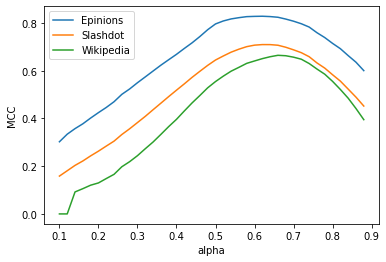

In [13]:
plt.figure()
alphas = np.arange(0.1,0.9,0.02)
for df in [epinions, slashdot, wikielec]:
    MCC = [0]*len(alphas)
    for i,alpha in enumerate(alphas):
        (_,_,_,_,_,_,_,MCC[i]) = weighted_average_predict(df, alpha)
    plt.plot(alphas,MCC)
    
plt.legend(("Epinions", "Slashdot", "Wikipedia"))
plt.xlabel("alpha")
plt.ylabel("MCC")
plt.show()

In [14]:
evaluation_results2 = evaluation_results.copy()
evaluation_results2 = evaluation_results2.rename_axis("Evaluation results 2.0", axis=1)

In [15]:
# Optimal alpha found by hand: 0.63
%time evaluation_results2["Epinions"] = weighted_average_predict(epinions, 0.63)

CPU times: user 16.7 s, sys: 97.1 ms, total: 16.8 s
Wall time: 16.8 s


In [16]:
# Optimal alpha found by hand: 0.63
%time evaluation_results2["Slashdot"] = weighted_average_predict(slashdot, 0.63)

CPU times: user 10.8 s, sys: 53.7 ms, total: 10.8 s
Wall time: 10.8 s


In [17]:
# Optimal alpha found by gradient descent: 0.66
%time evaluation_results2["Wikipedia"] = weighted_average_predict(wikielec, 0.66)

CPU times: user 1.81 s, sys: 7.03 ms, total: 1.82 s
Wall time: 1.82 s


In [18]:
display(evaluation_results.round(decimals=3))
display(evaluation_results2.round(decimals=3))

Evaluation results  Epinions  Slashdot  Wikipedia
Class   Score                                    
+1      Precision      0.948     0.879      0.859
        Recall         0.998     0.985      0.992
        F-score        0.972     0.929      0.921
-1      Precision      0.980     0.915      0.932
        Recall         0.684     0.537      0.396
        F-score        0.806     0.676      0.556
General Accuracy       0.952     0.884      0.866
        MCC            0.795     0.644      0.554

Evaluation results 2.0  Epinions  Slashdot  Wikipedia
Class   Score                                        
+1      Precision          0.970     0.934      0.924
        Recall             0.981     0.935      0.938
        F-score            0.975     0.934      0.931
-1      Precision          0.883     0.777      0.755
        Recall             0.821     0.773      0.712
        F-score            0.851     0.775      0.733
General Accuracy           0.958     0.898      0.890
        MCC                0.827     0.709      0.664

#### Sanity check
Just to verifiy that our algorithm gives plausible results, we can see that when we use an `alpha` parameter of 0 or 1, the accuracy becomes equal to the percentage of positive (`alpha=0`) and negative (`alpha=1`) edges in the datasets:

In [19]:
print("Accuracy: %.1f%%"% (weighted_average_predict(epinions, 0)[-2]*100))

Accuracy: 85.4%


In other words, what we just did is to predict that all edges are positive. Because there are 85.4% of positive edges in `epinions`, the accuracy becomes 85.4% as well. Note that in our last algorithm, the accuracy increased more than 10% with respect to the percentage of positive edges through all datasets.

#### Discussion
###### Score improvements
The second table shows our new results compared to the older ones (first table). Now that the classes are balanced, the results are much better. We can see the effect of this balance with the precision and the recall for the negative class which went from respectively (0.980, 0.684) to (0.883, 0.821). We can see that all f-scores increased when using a weight ponderation, especially the f-scores for the negative class. This is due to the fact that the recall for the negative class has significantly increased. The cost of this is that the precision for the negative class decreased but this decrease is lower than the recall increase making the overall statistics better. The higher recall for the negative class also induced a balancing of precision and recall for the positive class which are now very close. The accuracy didn't increase much, which is normal because we tried to balance the predictions rather than improve the number of correct predictions.

###### Mystery coefficient
Surprisingly, we can see that the optimal `alpha` parameter is pretty constant throughout all of the datasets (around 0.65). But what does this coefficient represent concretely? At first, we chose this coefficient to balance the positive and negative classes. But intuitively, the optimal coefficient would be based on the ratio of positive and negative edges. For example, if there are 85% of positive edges like in `epinions`, the intuition would be to give a weight of 0.85 to the negative weights (`alpha=0.85`) and 0.15 to the positive ones. But this is not the case here. All `alpha` from the different datasets are underestimated with respect to this intuition. Indeed, the percentage of positive edges for `epinions`, `slashdot` and `wikielec` are respectively 85.0%,	77.4% and 78.7% which are all way above our optimal parameter found of 0.65. What is even more surprising is how this optimal `alpha` keeps constant with different datasets and different ratios of positive/negative edges. This consistency goes toward the idea that this coefficient could have a broader significance. The first concrete hypothesis on the meaning of this coefficient would be that  **negative votes/ratings have more ease to tilt the scales than positive ones**. In other words, it confirms the fact that graphs often contain communities of condensed positives links where those communities are seperated by negative links. Indeed, it means that positive links are usually very condensed around nodes and that the average of outgoing/ingoing edges will definitely be positive (close to 1). On the other hand, negative links are often alone or close to a few postive links which make them a hard opponent against the positive links. So, as positive links are more condensed than negative ones, only a low `alpha` coefficient is required to make the negative links confrontable with positive links.

###### Winner Dataset
Even if `Wikipedia` has the lowest prediction scores in general, it is the dataset where the weight ponderation worked the best. This is very interesting as Wikipedia is indeed different from the other datasets. Its links are votes for adminship whereas the other datasets' links are more similar to "user ratings". If we consider the hypothesis stated above, that means that `Wikipedia` is the dataset which forms the most communities of positive votes. In other words, that means that votes are mostly oriented towards the same candidates and all other candidates only have a small impact on electors.

We also see on the last plot that `epinions` performs better than `slashdot` which performs better than `wikielec` in general. This is mostly related to the fact that larger datasets with higher percentages of positives will usually perform better because of the absolute number of positives which is larger.
###### Further research
Some further research could be made based on the same idea of algorithm.
- A first idea could be to also ponderate source and target nodes. For example, when comparing the avergage of outgoing edges from source and ingoing edges to target, we could give a higher importance to the target ingoing edges. We tried to implement this additional parameter but we only found optimals of 0.5 (equal importance), but maybe it couuld be an important factor on other datasets.   
- A second idea was to use the time at which the edges were formed a give a decreasing exponential weight to links formed further away in time. In could be interesting to test this idead on several temporal signed networks and compare them.
- It would also be interesting to continue this research on new datasets to see if the parameter `alpha`'s behavior stays consistent.

### Real predicitons 

#### Leave one out algorithm

The last prediction algorithm that we have seen is not a real prediction algorithm as it also used the edge to predict in the averages. But the purpose of the previous part was mostly to understand the parameters and how to use them. Now, we will implement a real "Leave One Out" algorithm where we do not consider the weight of the edge that we want to predict and where we predict one edge at a time, knowing all the remaining graph. We then iterate through all edges and predict their weights. This algorithm complexity is higher than the previous one and this is why the parameters search was mostly done with the previous algorithm. Fortunately, the assumptions made previously still hold with this algorithm. What changed here is that we cannot compute the source and target score attributes as we did before so we need to calculate the averages on each edge, which is why it takes more time.

In [20]:
def lvo_weighted_average_predict(dataframe, alpha):
    G = nx.from_pandas_edgelist(dataframe, source="Source", target="Target", 
                                edge_attr=["Weight"], create_using=nx.DiGraph())
    
    for e in G.edges:
        G.edges[e]['Modified Weight'] = (1-alpha) if G.edges[e]['Weight'] > 0 else -alpha
    
    for e in G.edges:
        # Calculate outgoing and ingoing weight averages for each edge without taking into account the edge to predict
        out_edges_weight = [G.get_edge_data(*edge)['Modified Weight'] for edge in G.out_edges(e[0]) if edge != e]
        in_edges_weight  = [G.get_edge_data(*edge)['Modified Weight'] for edge in G.in_edges(e[1])  if edge != e]
        
        # Lengths of source outgoing and target ingoing edge lists
        len_out = len(out_edges_weight)
        len_in  = len(in_edges_weight)
        
        # If both list lengths are 0 -> guess
        if 0 == len_out == len_in:
            G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        # If one of the two list lengths is 0 -> only consider one
        elif len_out == 0:
            t = np.mean(in_edges_weight)
            if t > 0:
                G.edges[e]["Predict"] = 1
            elif t < 0:
                G.edges[e]["Predict"] = -1
            # Case where t=0 -> guess
            else:
                 G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        elif len_in == 0:
            s = np.mean(out_edges_weight)
            if s > 0:
                G.edges[e]["Predict"] = 1
            elif s < 0:
                G.edges[e]["Predict"] = -1
            # Case where s=0 -> guess
            else:
                 G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        # Case where both list lenghts are above 0 -> same as previous algo
        else:
            s = np.mean(out_edges_weight)
            t = np.mean(in_edges_weight)
            if s*t > 0:
                if s > 0:
                    G.edges[e]["Predict"] = 1
                else:
                    G.edges[e]["Predict"] = -1

            elif s*t < 0:
                if s > 0:
                    if s > abs(t):
                        G.edges[e]["Predict"] = 1
                    elif s < abs(t):
                        G.edges[e]["Predict"] = -1
                    else:
                        G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
                else:
                    if abs(s) > t:
                        G.edges[e]["Predict"] = -1
                    elif abs(s) < t:
                        G.edges[e]["Predict"] = 1
                    else:
                        G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

            else:
                if s + t > 0:
                    G.edges[e]["Predict"] = 1
                elif s + t < 0:
                    G.edges[e]["Predict"] = -1
                else:
                    G.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

    return weighted_average_evaluation(G)

In [21]:
evaluation_results3 = evaluation_results.copy()
evaluation_results3 = evaluation_results3.rename_axis("Evaluation results 3.0", axis=1)

In [22]:
# Optimal alpha found by hand: 0.64
%time evaluation_results3["Epinions"] = lvo_weighted_average_predict(epinions, 0.64)

CPU times: user 4min 20s, sys: 812 ms, total: 4min 21s
Wall time: 4min 21s


In [23]:
# Optimal alpha found by hand: 0.64
%time evaluation_results3["Slashdot"] = lvo_weighted_average_predict(slashdot, 0.64)

CPU times: user 2min 3s, sys: 343 ms, total: 2min 3s
Wall time: 2min 3s


In [24]:
# Optimal alpha found by hand: 0.67
%time evaluation_results3["Wikipedia"] = lvo_weighted_average_predict(wikielec, 0.67)

CPU times: user 15.6 s, sys: 41.7 ms, total: 15.6 s
Wall time: 15.6 s


In [25]:
display(evaluation_results2.round(decimals=3))
display(evaluation_results3.round(decimals=3))

Evaluation results 2.0  Epinions  Slashdot  Wikipedia
Class   Score                                        
+1      Precision          0.970     0.934      0.924
        Recall             0.981     0.935      0.938
        F-score            0.975     0.934      0.931
-1      Precision          0.883     0.777      0.755
        Recall             0.821     0.773      0.712
        F-score            0.851     0.775      0.733
General Accuracy           0.958     0.898      0.890
        MCC                0.827     0.709      0.664

Evaluation results 3.0  Epinions  Slashdot  Wikipedia
Class   Score                                        
+1      Precision          0.955     0.913      0.915
        Recall             0.962     0.899      0.917
        F-score            0.959     0.906      0.916
-1      Precision          0.769     0.672      0.690
        Recall             0.740     0.707      0.685
        F-score            0.754     0.689      0.687
General Accuracy           0.929     0.856      0.868
        MCC                0.713     0.595      0.603

First of all, we can see that even though we tried to find the best parameters by hand, they stay very close to the ones we found before which confirms our hypothesis that this coefficient might be generalizable.

Second of all, we can see that the prediction performs less well than before mostly because this time, we didn't take into account the edge that we want to predict. The most affected score is the recall for the negative class just as before. Based on the MCC coefficient, we also see that the less affected dataset is `Wikipedia`.
#### Whole partition out algorithm

This next algorithm `wpo_weighted_average_predict` is a "whole part out" algorithm which tries to predict edges when a certain percentage of random edges is removed from the graph. So this time, we only focus on predicting a certain group of edges compared to the previous algorithm where we iterated over all edges. The difference of implementation compared to the previous "leave one out" algorithm is that this algorithm builds a graph of unknown edges only, so that it can run faster. Also, we can set source and target score attributes, as in our first algorithm, before iterating over the edges so that the complexity is decreased a lot. Lastly, when we have extracted the random samples to predict, we replace their weight values by NaN so that we can compute the `np.nanmean` which will calculate the mean of every known weight and discard all weights with NaN values.

In [26]:
def wpo_weighted_average_predict(dataframe, alpha, test_percent):
    
    # Get random samples (811 seed)
    df = dataframe.sample(round(test_percent*dataframe.shape[0]), random_state=811) 

    G = nx.from_pandas_edgelist(dataframe, source="Source", target="Target", 
                                edge_attr=["Weight"], create_using=nx.DiGraph())
    
    # Build the graph of unknown edges only
    G_unknown = nx.from_pandas_edgelist(df, source="Source", target="Target", 
                                edge_attr=["Weight"], create_using=nx.DiGraph())

    # New "Modified Weight" edge attribute which takes nan if the edge is to predict
    for e in G.edges:
        if e in G_unknown.edges:
            G.edges[e]['Modified Weight'] = np.nan
        else:
            G.edges[e]['Modified Weight'] = (1-alpha) if G.edges[e]['Weight'] > 0 else -alpha
        
    for node in G_unknown.nodes:
        out_edges_weight = [G.get_edge_data(*e)['Modified Weight'] for e in G.out_edges(node)]
        in_edges_weight  = [G.get_edge_data(*e)['Modified Weight'] for e in G.in_edges(node)]
        # Ignore mean of empty array warning which returns nan and which is managed afterwards
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            G_unknown.nodes[node]["Source score"] = np.nanmean(out_edges_weight)
            G_unknown.nodes[node]["Target score"] = np.nanmean(in_edges_weight)
            
    for e in G_unknown.edges:
        s = G_unknown.nodes[e[0]]['Source score']
        t = G_unknown.nodes[e[1]]['Target score']
        # Case where both lists of weights were empty
        if np.nan == s == t:
            G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        # Case where one of the two lists of weights was empty
        elif s == np.nan:
            if t > 0:
                G_unknown.edges[e]["Predict"] = 1
            elif t < 0:
                G_unknown.edges[e]["Predict"] = -1
            else:
                G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        elif t == np.nan:
            if s > 0:
                G_unknown.edges[e]["Predict"] = 1
            elif s < 0:
                G_unknown.edges[e]["Predict"] = -1
            else:
                G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
        else:
            if s*t > 0:
                if s > 0:
                    G_unknown.edges[e]["Predict"] = 1
                else:
                    G_unknown.edges[e]["Predict"] = -1

            elif s*t < 0:
                if s > 0:
                    if s > abs(t):
                        G_unknown.edges[e]["Predict"] = 1
                    elif s < abs(t):
                        G_unknown.edges[e]["Predict"] = -1
                    else:
                        G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
                else:
                    if abs(s) > t:
                        G_unknown.edges[e]["Predict"] = -1
                    elif abs(s) < t:
                        G_unknown.edges[e]["Predict"] = 1
                    else:
                        G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)
            else:
                if s + t > 0:
                    G_unknown.edges[e]["Predict"] = 1
                elif s + t < 0:
                    G_unknown.edges[e]["Predict"] = -1
                else:
                    G_unknown.edges[e]["Predict"] = (1 if random() < 0.5 else -1)

    return weighted_average_evaluation(G_unknown)

###### Wikipedia in fire ?

We can now check the performance of this algorithm for different `alpha` to check if it is still consistent with previous values found. We decide to drop 20% of the edges in the dataset:

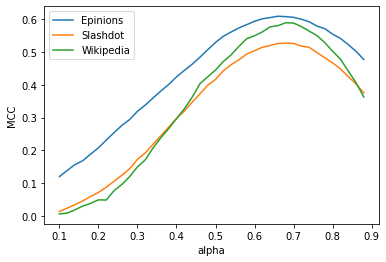

In [27]:
plt.figure()
alphas = np.arange(0.1,0.9,0.02)
for df in [epinions, slashdot, wikielec]:
    MCC = [0]*len(alphas)
    for i,alpha in enumerate(alphas):
        (_,_,_,_,_,_,_,MCC[i]) = wpo_weighted_average_predict(df, alpha,0.2)
    plt.plot(alphas,MCC)
    
plt.legend(("Epinions", "Slashdot", "Wikipedia"))
plt.xlabel("alpha")
plt.ylabel("MCC")
plt.show()

For all the changes that we have made so far, it's still surprising how this parameter `alpha` stays consistent. Here again, we can see on the plot that the optimal `alpha` lies around 0.66 for each of the datasets. Even more surprising, we can see that `Wikipedia` benefits incredibly well from this parameter tuning with the "whole part out" algorithm and its predictions even beat `slashdot` ones. This confirms what we said before on the fact that wikipedia is especially suited for our algorithm and this parameter tuning. The fact that it highly benefits from this parameter tuning implies that a lot of positive communities are found in the dataset and that those communities are most likely separated by less dense communities with more negative votes. 

Secondly, we can see that since the beginning, when the performance of an algorithm increases, `Wikipedia` is the dataset which has the largest relative increase of performance (for example when going from `evaluation_results1` to `evaluation_results2`) and when the performance of an algorithm decreases, `Wikipedia` is the dataset which has the lowest relative decrease of performance (for example when going from `evaluation_results1` to `evaluation_results2`). We can see that on the plot where `Wikipedia` doesn't actually perform better than `slashdot` but performs less worse. This robustness found with `Wikipedia` implies that our algorithm is especially suited for this dataset. As we said at the beginning, the idea behind the algorithm is that for each edge, it quantifies the personnality of the source node and the performance of the target node. So this idea of personnality/performance works especially well for `Wikipedia`. This is mostly due to the electoral environment imposed by the dataset where people usually know more about others and their choices can have an impact on the future whereas this impact is not found in the other datasets.

In [28]:
evaluation_results4 = evaluation_results.copy()
evaluation_results4 = evaluation_results4.rename_axis("Evaluation results 4.0", axis=1)

In [29]:
%time evaluation_results4["Epinions"] = wpo_weighted_average_predict(epinions, 0.65, 0.2)

CPU times: user 12.7 s, sys: 60.9 ms, total: 12.8 s
Wall time: 12.8 s


In [30]:
%time evaluation_results4["Slashdot"] = wpo_weighted_average_predict(slashdot, 0.65, 0.2)

CPU times: user 9.42 s, sys: 79.6 ms, total: 9.49 s
Wall time: 9.47 s


In [31]:
%time evaluation_results4["Wikipedia"] = wpo_weighted_average_predict(wikielec, 0.65, 0.2)

CPU times: user 1.31 s, sys: 6.54 ms, total: 1.32 s
Wall time: 1.32 s


In [32]:
display(evaluation_results3.round(decimals=3))
display(evaluation_results4.round(decimals=3))

Evaluation results 3.0  Epinions  Slashdot  Wikipedia
Class   Score                                        
+1      Precision          0.955     0.913      0.915
        Recall             0.962     0.899      0.917
        F-score            0.959     0.906      0.916
-1      Precision          0.769     0.672      0.690
        Recall             0.740     0.707      0.685
        F-score            0.754     0.689      0.687
General Accuracy           0.929     0.856      0.868
        MCC                0.713     0.595      0.603

Evaluation results 4.0  Epinions  Slashdot  Wikipedia
Class   Score                                        
+1      Precision          0.954     0.907      0.906
        Recall             0.916     0.855      0.926
        F-score            0.935     0.880      0.916
-1      Precision          0.606     0.584      0.700
        Recall             0.746     0.700      0.641
        F-score            0.668     0.637      0.669
General Accuracy           0.891     0.820      0.866
        MCC                0.609     0.523      0.586

From the prediction point of view, as one may have guessed, the "whole part out" algorithm performs less well than the previous ones as several edges are removed from the graph. Indeed, a node can now loose several of its edges and the prediction based on the average of its weights becomes less efficient. As we have just discussed, we can see that the MCC from `Wikipedia` decrease less than the one of the other datasets. We also see that here again, the drop in the MCC is mostly due to the drop on the recall of the negative class.

Lastly, just out of curiosity we can make a last check on the consistency of the parameter `alpha` if we change the percentage of edges that we want to predict in the graph. We now drop 50% of the edges in the graph.

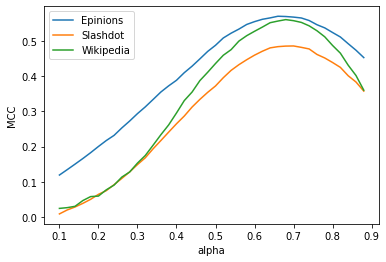

In [33]:
plt.figure()
alphas = np.arange(0.1,0.9,0.02)
for df in [epinions, slashdot, wikielec]:
    MCC = [0]*len(alphas)
    for i,alpha in enumerate(alphas):
        (_,_,_,_,_,_,_,MCC[i]) = wpo_weighted_average_predict(df, alpha,0.5)
    plt.plot(alphas,MCC)
    
plt.legend(("Epinions", "Slashdot", "Wikipedia"))
plt.xlabel("alpha")
plt.ylabel("MCC")
plt.show()

Here again, we can see that that the parameter `alpha` stays consistent !

### Conclusion
In this part, we have implemented an algorithm that allows to predict the edge of a weight based on its local environment. The prediction results were satisfying as we managed to balance the scores of the two classes thanks to the parameter `alpha`, while keeping an accuracy which is above the percentage of positive weights in the network. Furthermore, we manage to do some concrete hypothesis on the value of this `alpha` parameter and why is it as consistent as it is. Lastly, we have seen that `Wikipedia` is a dataset which benefits a lot from the tuning that `alpha` offers and from the personnality/performance philosophy of our algorithms.

## Triad type prediction - Global <a id='TTP'></a>

### Introduction
#### Idea
In this part, we compare 3 algorithms for predicting unknown signs of edges. We compare Algo3, that predicts the signs based on the percentage of triads of different types, with Algo2 and Algo4, which are baseline algorithms. To simulate the experience, we split our edges of the datasets `epinions`, `slashdot` and `wikipedia` into a known set (80% of the data, with known edges) and an unknown set (20% of the data, edges with unknown signs). Depending on the algorithms, we make certain computations on the known data, and use these results to predict the signs of new edges.
The algorithms are the following :
<br>
<br>Algorithm 2 (Baseline Prediction 1): We only predict positive edges.
<br>
<br>Algorithm 4 (Baseline Prediction 2): We compute the percentage of positive and negative edges on the known network. We then predict a sign + with the same percentage of positive edges, and a sign - with the same percentage of negative edges
<br> 
<br>Algorithm 3 : We first compute the percentage of the triads of the different types on the known data. Then, to predict the sign of a new edge u->v, we first compute how many new triads this edge will add. Then,  Based on the calculated percentage of triads on the known 80% data set, we then predict the sign of the edge in order to match that percentage in expectation

#### New triad
The function `new_triad` computes how many new triads of each type the new edge u->v will add when we add this edge to the graph. We don't know the sign of the new edge, so the types of triads depend only on two known edges, and therefore the different possible types are ++, +- , -- .
The output is an array which size denotes the number of triads that will be created when adding the edge to the Graph, with as elements the sign of the different triads that will be created. The signs can be 2, 0 or - 2. It is 2 if a new edge contributes to a triad which has already 2 positive edges, 0 if a new edge contributes to a triad which has already 1 positive and 1 negative edge, and -2 if a new edge contribues to a triad which has already 2 negative edges 
Therefore, if the sign is 2 and we predict that an edge is +, then the triad created will be +++, else it will be ++-

In [34]:
def new_triad(u,v, Array) : 
    """"
    Input :
    edge u->v with unknown sign 
    Array : known existing Graph, with known signed edges
    
    Output : 
    Array of size(#number of triads created), with for each line the sum of the signs of the two known edges of the created 
    triad. The elementsof the array are therefore : 2 (++) , 0 (+- or -+), -2(--)
    """
    #check if there exits edges w-> u in the known network, for all w  ( predecessors of u )
    w_u = Array[np.where(Array[:,1]==u)]
    pred_u = set(w_u[:,0])
    #check if there exits edges u->w in the known network, for all w ( successor of u ) 
    u_w = Array[np.where(Array[:,0]==u)]
    succ_u = set(u_w[:,1])
    #check if there exits edges w-> v in the known network, for all w  ( predecessors of v )
    w_v = Array[np.where(Array[:,1]==v)]
    pred_v = set(w_v[:,0])
    #check if there exits edges w-> v in the known network, for all w  ( predecessors of v )
    v_w = Array[np.where(Array[:,0]==v)]
    succ_v = set(v_w[:,1])
    
    # initializations
    signs1 = np.array([]) ; signs2 = np.array([]) ; 
    signs3 = np.array([]) ; signs4 = np.array([]) ; 
    size1 =  0 ; size2 =  0 ; size3 =  0 ; size4 =  0 ; 
    tot_signs = []
    
    #Case 1 : we found a triad u-> w , w-> v ( u->v every time )
    case1 = succ_u.intersection(pred_v) 
    # how many triads they are of this configration
    a1 = len(case1)
    if a1 > 0 : 
        if a1 > 1 : 
            # there are a1 types of this configuration
            signs1 = np.zeros((a1,2))
            for i in range(0,a1) : 
                #We find the sign of u->w and w->v in order to define its type 
                signs1[i,0] = u_w[i,2]
                signs1[i,1] = w_v[i,2]
            size1 = size4 = np.shape(signs1)[0]
            # we add this triad to the list containing the signs of the new triads created
            tot_signs = tot_signs + list(np.sum(signs1, axis = 1 ))
        else : 
            # 1 type of triad in case1
            signs1 = np.array([u_w[0,2], w_v[0,2]])
            size1 = 1 
            # add this triad to the list containing the signs of the new triads created
            tot_signs = tot_signs + [np.sum(signs1)]
            
    #Case 1 : we found a triad u-> w , v->w ( u->v every time )
    case2 = succ_u.intersection(succ_v)
    a2 = len(case2)
    if a2 > 0 : 
        
        if a2 > 1 : 
            # multiple case 2 configurations
            signs2 = np.zeros((a2,2))
            for i in range(0,a2) : 
                # sign of u->w 
                signs2[i,0] = u_w[i,2]
                # sign of v->w
                signs2[i,1] = v_w[i,2]
            size2 = np.shape(signs4)[0]
            #add the sign of the new triads 
            tot_signs = tot_signs + list(np.sum(signs2, axis = 1 ))
        else : 
            # sign of u->w and v_>v
            signs2 = np.array([u_w[0,2], v_w[0,2]])
            size2 = 1
            # add the sign of the new triads
            tot_signs = tot_signs + [np.sum(signs2)]
    
    #Case 3 : we found a triad w-> u , w->v ( u->v every time )
    case3 = pred_u.intersection(pred_v)
    a3 = len(case3)
    if a3 > 0 : 
        if a3 > 1 : 
            signs3 = np.zeros((a3,2))
            for i in range(0,a3) : 
                #multiple case 3 configurations
                #sign of w->u
                signs3[i,0] = w_u[i,2]
                #sign of w->v
                signs3[i,1] = w_v[i,2]
            size3 = np.shape(signs4)[0]
            # add the sign of the triad
            tot_signs = tot_signs + list(np.sum(signs3, axis = 1 ))
        else : 
            # One case 3 configuration
            signs3 = np.array([w_u[0,2], w_v[0,2]])
            size3 = 1
            # add the sign of the triad
            tot_signs = tot_signs + [np.sum(signs3)]
            
    #We found a new created triad, with w->u and v->w
    case4 = pred_u.intersection(succ_v) 
    a4 = len(case4)
    if a4 > 0 : 
        if a4 > 1 : 
            signs4 = np.zeros((a4,2))
            for i in range(0,a4) : 
                #case 4 contains multiple configurations
                # sign of w->u
                signs4[i,0] = w_u[i,2]
                #sign of v->w
                signs4[i,1] = v_w[i,2]
            size4 = np.shape(signs4)[0]
            tot4 = np.sum(signs4, axis = 1 )
            # add the sign of the new triad
            tot_signs = tot_signs + list(np.sum(signs4, axis = 1 ))
        else : 
            #One case 4 configuration
            signs4 = np.array([w_u[0,2], v_w[0,2]])
            size4 = 1 
            tot_signs = tot_signs + [np.sum(signs4)]
    number_of_new_triads = size1 + size2 + size3 + size4
    # returns the list of triads with its total sum 
    
    return tot_signs

#### Help functions
The two following functions are taken from the replication of **Table 3** of the "Signed Networks in Social Media" paper from one of the team member making this creative extension. Therefore, we will not elaborate on their implementations and will simply use them in the case of our study.

In [35]:
def triads(dataframe):
    """ Finds all groups of three nodes in a graph and lists all edges between these three nodes """
    
    global results_table3
    global d 
    
    d = {
        '+++':0,
        '+--':0,
        '++-':0,
        '---':0
        }

    # Create graph for the data
    G = nx.DiGraph()
    G.add_weighted_edges_from(map(tuple, dataframe.values))

    # Save an undirected version of the graph for neighbors search
    G_undirected = G.to_undirected()

    # For each node
    for node in list(G_undirected.nodes()):
        neighbor_done = []
        # Iterate through node neighbors
        for neighbor in nx.neighbors(G_undirected,node):
            # Avoids self-loops
            if neighbor != node:
                # Avoids itterating multiple times the same triad
                neighbor_done.append(neighbor)
                # Iterate through common neighbors of the node and the neighbor
                for common in nx.common_neighbors(G_undirected,node,neighbor):
                    if common not in neighbor_done:
                        # Get all edges with their weights in the 3 nodes subgraph
                        triad_type([(u,v,G[u][v]['weight']) 
                                    for (u,v) in permutations([node,neighbor,common],2) if (u,v) in G.edges])
        # Avoids going through same triads twice and greatly diminish complexity
        G_undirected.remove_node(node)
    d

In [36]:
def triad_type(triad_edges):
    """ Given all edges between three nodes, find all different types of triads between these three nodes """
    n = len(triad_edges)
    s = sum([edge[-1] for edge in triad_edges])
    r = []
    
    done = []
    for (u,v,w) in triad_edges:
        # Appends the recirpocal products withtout duplicating it
        if (v,u,w) in triad_edges and (v,u,w) not in done:
            r.append(1)
            done.append((u,v,w))
        if (v,u,-w) in triad_edges and (v,u,-w) not in done:
            r.append(-1)
            done.append((u,v,w))

    if n == 3:
        if len(r) != 0:
            raise ValueError('must have no reciprocal pair of edges')
        if s == 3:
            d['+++'] += 1
        elif s == 1:
            d['++-'] += 1
        elif s == -1:
            d['+--'] += 1
        elif s == -3:
            d['---'] += 1
        else:
            raise ValueError('unvalid sum of weights for triad with 3 edges')
            
    elif n == 4:   
        if len(r) != 1:
            raise ValueError('must have one reciprocal pair of edges')
        if r[0] == 1:
            if s == 4:
                d['+++'] += 2
            elif s == 2:
                d['++-'] += 2
            elif s == 0:
                for (u,v,w) in triad_edges:
                    if (v,u,w) in triad_edges:
                        if w == 1:
                            d['+--'] += 1
                        elif w == -1:
                            d['++-'] += 1
                        else:
                            raise ValueError('unvalid weight')
            elif s == -2:
                d['+--'] += 2
            elif s == -4:
                d['---'] += 2
            else:
                raise ValueError('unvalid sum of weights for triad with 4 edges')
        elif r[0] == -1:
            if s == 2:
                d['+++'] += 1
                d['++-'] += 1
            elif s == 0:
                d['++-'] += 1
                d['+--'] += 1
            elif s == -2:
                d['+--'] += 1
                d['---'] += 1
            else:
                 raise ValueError('unvalid sum of weights for triad with 4 edges')
        else:
            raise ValueError('unvalid weight multiplication')
                
    elif n == 5:
        if len(r) != 2:
            raise ValueError('must have 2 reciprocal pairs of edges')
        if r[0] == 1 and r[1] == 1:
            if s == 5:
                d['+++'] += 4
            elif s == 3 or s == 1:
                d['++-'] += 4
            elif s == -1 or s == -3:
                d['+--'] += 4
            elif s == -5:
                d['---'] += 4
            else:
                raise ValueError('unvalid sum of weights for triad with 5 edges')
        elif (r[0]*r[1]) < 0:
            if s == 3:
                d['+++'] += 2
                d['++-'] += 2
            elif s == 1 or s == -1:
                d['++-'] += 2
                d['+--'] += 2
            elif s == -3:
                d['+--'] += 2
                d['---'] += 2
            else:
                raise ValueError('unvalid sum of weights for triad with 5 edges')
        elif  r[0] == -1 and r[1] == -1:
            if s == 1:
                d['+++'] += 1
                d['++-'] += 2
                d['+--'] += 1
            elif s == -1:
                d['++-'] += 1
                d['+--'] += 2
                d['---'] += 1
            else:
                raise ValueError('unvalid sum of weights for triad with 5 edges')
        else:
            raise ValueError('unvalid weight multiplication')
            
    elif n == 6:
        if len(r) != 3:
            raise ValueError('must have 3 reciprocal pairs of edges')
        if r[0] == 1 and r[1] == 1 and r[2] == 1:
            if s == 6:
                d['+++'] += 8
            elif s == 2:
                d['++-'] += 8
            elif s == -2:
                d['+--'] += 8
            elif s == -6:
                d['---'] += 8
            else:
                raise ValueError('unvalid sum of weights for triad with 6 edges')
        elif r[0] == -1 and r[1] == -1 and r[2] == -1:
            if s == 0:
                d['+++'] += 1
                d['++-'] += 3
                d['+--'] += 3
                d['---'] += 1
            else:
                raise ValueError('unvalid sum of weights for triad with 6 edges')
        elif (r[0]*r[1]*r[2]) > 0:
            if s == 2:
                d['+++'] += 2
                d['++-'] += 4
                d['+--'] += 2
            elif s == -2:
                d['++-'] += 2
                d['+--'] += 4
                d['---'] += 2
            else:
                raise ValueError('unvalid sum of weights for triad with 6 edges')
        elif (r[0]*r[1]*r[2]) < 0:
            if s == 4:
                d['+++'] += 4
                d['++-'] += 4         
            elif s == 0:
                d['++-'] += 4
                d['+--'] += 4
            elif s == -4:
                d['+--'] += 4
                d['---'] += 4
            else:
                raise ValueError('unvalid sum of weights for triad with 6 edges')   
        else:
            raise ValueError('unvalid weight multiplication')
            
    else:
        raise ValueError('unvalid number of edges in a triad')
        

### Algorithm 3
Algorithm 3 which predicts the sign based on percentages of triads of the known network.
It is better to illustrate how it works with an example : 
<br>
<br> Eg : If we know that adding edge(u,v) will create a single triad with two edges that are  already ++ , and that we predict a +, this edge will create a triad of type +++. If, however, we predict a -1, it will create a triad of type +--. 
<br>Therefore, knowing that we have a ++ triad, there is a probability that we have a +++ and
    a probability that we have a ++-. What we are looking for is the conditional probability that, knowing the triad is ++, that the resulting triad is +++, and that is it +--. <br>
    Having the percentage of triads already computed in the known data (80%), we can compute those conditional probabilities. In our example we thus have P(T3 | ++) = $\frac{p(T3)}{p(T2)+p(T3)} $ = probability of giving a sign + to this edge( p(Ti) refers to the percentage of triads of type Ti). In that case, we will thus predict that the edge is positive with the same probability. To simulate this stochastic process, we create for each edge a number u generated uniform random distribution in (0,1). When $ u \leq P(T3 | ++)$, we give a sign  +, else we give a sign -. 
    <br>
    <br>
    An edge can create multiple triads, so we repeat this procedure for each triangle the edge creates, and take the mean of the obtain probabilities.
  <br> One additional feature is that we eventually give a parameter to some procedures. For example, when the potential triad is ++, we may want to increase its probability to become +++ in some cases. There are thus 3 weights for each potential triad (++, -+, --). The weights in our procedure were defined through manual iteration and are constant for each dataset. We discuss late in the notebook how these weights can actually be optimized to obtain better results

In [37]:
def algorithm_3(triad_types, p_T3, p_T2, p_T1, p_T0): 
    ''' predicts the sign based on percentages
    Inputs : 
    triad_types : potentil triads the new edge creates, with the signs 
    p_Ti : percentage of triads of types Ti
    
    Output : predicted sign
    '''
    # random variable to simulate stochastic process
    u_new = np.random.uniform(0,1)
    #As explained in the report, those weights are arbitrary here, and can be optimized to have better results.
    
    # coeff_1 increases the procedure of ++ -> +++
    coeff_1 = p_T3 * 1.5
    # coeff_2 increases the procedure +-> ++-  
    # 50 may seem big compared to 1.5, but p_(TO) is very small 
    coeff_2 = p_T0 * 50
    # coeff_3 increases the procedure of -- -> --
     # 30 may seem big compared to 1.5, but p_(T1, T2) are  small relative to P_T3 
    coeff_3 = p_T2 * 30
    N = np.shape(triad_types)[0]
    positif_percentages = np.zeros((N,1))
    
    for i in range(0,N ) : 
        triad = triad_types[i]
        if triad == 2 : 
            # prob for the edge positive if the triad is ++ 
            positif_percentages[i] = (coeff_1*p_T3) / (p_T3 + p_T2) #give more weight 
        elif triad == 0 : 
            # prob for the edge positive if the triad is +- 
            positif_percentages[i] = (p_T2 / coeff_3 ) / (p_T1 + p_T2) # give less weight
        else : 
            # prob for the edge positive if the triad is --
            positif_percentages[i] = ((1/coeff_2)*p_T1) / (p_T1 + p_T0) #less weight, => when --, we want more often a --- 
            
    # we take the average of the probabilities to give a +     
    mean_positive_perc = np.mean(positif_percentages)
    if u_new<= mean_positive_perc : # in average, it will predict 1 with a percentage of mean_positive_perc
        sign = 1 
    else : 
        sign = -1 
    return sign  

### Algorithm 4
With the percentage of positive edges computed on the known data set, we predict a sign + with the same percentage.
To simulate that, we use like in the above algorithms a uniform random variable. If u is inferior to this percentage, we predict a +. 
In expectation, we will thus predict a + or a - with the same percentages

In [38]:
def algorithm_4(we_dont_care, POS_perc) : 
    "Basic Algo, knowing the percentage of positive edge Beta, we give a new edge a + Beta% of the time"
    randomito = np.random.uniform(0,1)
    pos = POS_perc ;
    if randomito <= pos : 
        sign_ = 1
    else : 
        sign_ = -1 
    return sign_

`prediction_dip` is the function that predicts the signs of all the unknown edges with the 3 different algorithms. We iterate through the unknow edges, and finding the a prediction for each edge with the 3 algorithms

In [39]:
def prediction(array_unknown, array_known, p_T3, p_T2, p_T1, p_T0, POS_perc )   : 
    """
    Parameters: 
    array_unknown : contains the unknown edges that we want to predict
    array_known : known edges 
    p-Ti : percentage of Ti type in known network
    POS_perc : percentage of positive edges in known network 
    
    Outputs : 
    array_unknown_i : edges of array_unknown predicted with Algoi
    Confusion matrix with each Algo
    """

    #Initialization of TP, FP, TN, FN. 2 refers to Algo2, 3 to Algo3 and 4 to Algo4
    true_pos2 = 0;true_pos3 = 0;true_pos4 = 0;
    false_pos2 = 0;false_pos3 = 0;false_pos4 = 0
    true_neg2 = 0;true_neg3 = 0;true_neg4 = 0;
    false_neg2 = 0 ;false_neg3 = 0 ;false_neg4 = 0 ;
     
    #Number of edges we need to predict 
    longueur = np.shape(array_unknown)[0]
    #Initialisation of predictions
    array_unknown_2 = np.zeros((longueur, 3))
    array_unknown_3 = np.zeros((longueur, 3))
    array_unknown_4 = np.zeros((longueur, 3))
      
    #Iteration through all the unknow edges for prediction ( u->v)
    for i in range(0, longueur) : 
        # Node u 
        u = array_unknown[i,0]
        # Node v 
        v = array_unknown[i,1]
        # The number of triads with its signed created when adding edge u->v to known graph 
        new_triads = np.array(new_triad(u,v,array_known))
        
        if np.shape(new_triads)[0] == 0 :  
            #Here, we found that the edge u->v doesn't create a triad. Algo 2 and Algo 4 work the same, however
            # we cannot use Algo3. In this case ( which is minor and happends very rarely) , we use the same as Algo4 to predict
            # edges, with the percentage of positive edges;
            
            # Random unfirorm variable to simulate randomness
            u_random = np.random.uniform(0,1) 
            if u_random<= POS_perc : 
                # we predict a 1
                array_unknown_2[i,:] = [u,v,1]
                array_unknown_3[i,:] = [u,v,1]
                array_unknown_4[i,:] = [u,v,1]
            else : 
                # Algo 2 always predicts a 1
                array_unknown_2[i,:] = [u,v,1] 
                # we predict a -1 
                array_unknown_3[i,:] = [u,v,-1]
                array_unknown_4[i,:] = [u,v,-1]
            continue 
            
        #sign2 refers to sign predicted by Algo2, sign3 by Algo3, sign4 by Algo4
        #sign2 always predicts a 1
        sign2 = 1 
        #Algo 3 to predict sign3
        sign3 = algorithm_3(new_triads,  p_T3, p_T2, p_T1, p_T0)
        #Algo 4 to predict sign4
        sign4 = algorithm_4(new_triads, POS_perc)
        # fill the array with the predicted signs
        array_unknown_2[i,:] = [u,v,sign2] 
        array_unknown_3[i,:] = [u,v,sign3]
        array_unknown_4[i,:] = [u,v,sign4]
        
        #Find TP, FP, TP, FN in order to analyse results 
        if array_unknown[i,2] == 1 : # positive 
            
            if sign3 == 1 : 
                true_pos3 += 1 # its a 1 and we predicted a 1 
            else : 
                false_neg3 +=1 #its a 1 and we predicted a -1 
            if sign2 == 1 : 
                true_pos2 += 1 # its a 1 and we predicted a 1 
            else : 
                false_neg2 +=1 #its a 1 and we predicted a -1 
            if sign4 == 1 : 
                true_pos4 += 1 # its a 1 and we predicted a 1 
            else : 
                false_neg4 +=1 #its a 1 and we predicted a -1 
                
        else : 
            
            if sign3 == -1 : 
                true_neg3 += 1 # its a -1 and we predicted a -1 
            else : 
                false_pos3 +=1 #its a -1 and we predicted a 1
            if sign2 == -1 : 
                true_neg2 += 1 # its a -1 and we predicted a -1 
            else : 
                false_pos2 +=1 #its a -1 and we predicted a 1
            if sign4 == -1 : 
                true_neg4 += 1 # its a -1 and we predicted a -1 
            else : 
                false_pos4 +=1 #its a -1 and we predicted a 1
                
    
    # convert to int    
    array_unknown_2 = array_unknown_2.astype(int)
    array_unknown_3 = array_unknown_3.astype(int)
    array_unknown_4 = array_unknown_4.astype(int)
    
    #confusion matrix 
    all_perc_2 = np.array([[true_pos2, false_pos2],[false_neg2, true_neg2]])
    all_perc_3 = np.array([[true_pos3, false_pos3],[false_neg3, true_neg3]])
    all_perc_4 = np.array([[true_pos4, false_pos4],[false_neg4, true_neg4]])
    return array_unknown_2, array_unknown_3, array_unknown_4, all_perc_2, all_perc_3, all_perc_4


This functions shuffles the DataFrame into a known set (80% of the data), and an unknown set on (20%), on  which we will predict the signs

In [40]:
def shuffle_array(data_frame) :
    "shuffle the dataFrame to simulate an experience, with 80% as known data, 20% as unknown where we don't know the sign"
    array_data = np.array(data_frame)
    array_shuffle = np.take(array_data,np.random.permutation(array_data.shape[0]),axis=0,out=array_data)
    size_80 = int(0.80*len(data_frame))
    known_data = array_shuffle[0:size_80,:]; unknown_data = array_shuffle[size_80:,:]; 
    return known_data, unknown_data

The following 5 functions allow to analyse the results of predictions. The first one computes the number of resulting triads with the different output of the algorithms. The second one computes the accuracy on the number of triads compare to the true numbers. 
<br> The third function computes precisions, recall, negative predicted value, selectivity, F1_score, accuracy and MCC
<br> The fourth function builds a dataFrame with the results on prediction to print them
<br> The fifth function builds a dataFrame with the results on predictions of triads to print them

In [41]:
def triad_all_types(data_frame) : 
    "Computes the number of triads of the DataFrame and outputs the number for each type"
    triads(data_frame)
    T3 = d['+++'] ; T1 = d['+--'] ; T2 = d['++-'] ; T0 = d['---']
    return T3, T1, T2, T0

def percentage(real, estimate) : 
    "Computes the percentage of triads of each type"
    return np.array([estimate[0]/real[0],estimate[1]/real[1],estimate[2]/real[2],estimate[3]/real[3] ])

def statistic_accuracy(confusion_matrix) :
    "compute statistics based on the confusion matrix "
    TP = confusion_matrix[0,0]
    FP = confusion_matrix[0,1]
    FN = confusion_matrix[1,0]
    TN = confusion_matrix[1,1]
    precision = round(TP/(TP+FP),2) if TP + FP != 0 else 0 
    recall    = round(TP/(TP+FN),2) if TP + FN != 0 else 0
    negative_pred_value = round(TN/(TN+FN),2) if TN + FN != 0 else 0
    selectivity    = round(TN/(TN+FP),2) if TN + FP != 0 else 0 
    F_score = round((2*precision*recall/(precision + recall)),2) if precision + recall != 0 else 0
    accuracy = (TP+TN)/(TP+TN+FP+FN)
   
    if (TP+FP) == 0 or (TP+FN) == 0 or (FP+TN) == 0 or (FN+TN) == 0:
        MCC = int(0)
    else:
        MCC = round((TP*TN - FP*FN)/(np.sqrt(TP+FP)*np.sqrt(TP+FN)*np.sqrt(TN+FP)*np.sqrt(TN+FN)),2)
    
    return precision, recall, negative_pred_value, selectivity, F_score, accuracy, MCC

def build_statistics(Precisions, Recalls, negative_preds, F_scores, accuracies, MCCs, Selectivities) : 
    "Builds a DataFrame to compare the results of the 3 Algorithms "
    rows_name = ['Algo2', 'Algo3', 'Algo4']
    statistics = {'Precision':Precisions,'Recall':Recalls,'Negative_pred':negative_preds,'Selectivity': Selectivities ,'F_score':F_scores,'Accuracy':accuracies,'MCC':MCCs }
    columns_name = ['Precision', 'Recall', 'Negative_pred','Selectivity', 'F_score','Accuracy', 'MCC']
    df_statistics = pd.DataFrame( statistics, index = rows_name , columns = columns_name)
    return df_statistics

def build_triad_stats(T3s,p_T3s,T2s,p_T2s,T1s,p_T1s,T0s,p_T0s) : 
    "Builds a DataFrame to compare the results of the 3 Algorithms "
    rows_name = ['Real Triads','Algo2', 'Algo3', 'Algo4']
    statistics = {'T3':T3s,'%T3':p_T3s,'T2':T2s,'%T2':p_T2s ,'T1':T1s,'%T1':p_T1s,'T0':T0s,'%T0': p_T0s  }
    columns_name = ['T3', '%T3', 'T2','%T2', 'T1','%T1', 'T0', '%T0']
    df_stat_triads = pd.DataFrame( statistics, index = rows_name , columns = columns_name)
    return df_stat_triads

### Main function 
This is the main function computing the results. It predicts the edges with the different algorithms, computes the statistics to analyse the predictions (precision etc, as defined above), computes the resulting
number of triads for each algorithm, and compares the results with the true 100% data Set.

In [42]:
def different_algo(Data_Frame) : 
    """
    Parameters :
    Data_Frame : 100% of the known data
    
    Ouput :
    Data_Frame with the statistics on the performance of the 3 algorithms
    """
    # shuffle date into a known set and un unknown set
    known_df, unknown_df = shuffle_array(Data_Frame)
    # Percentage of positive edges in the known set
    Pos_df = np.shape(known_df[known_df[:,2]==1])[0]/np.shape(known_df)[0]
    #Number of triads in the known set
    T3_known, T1_known, T2_known, T0_known = triad_all_types(pd.DataFrame(data = known_df ))
    tot_known = T3_known + T2_known +  T1_known +  T0_known
    #Percenateg of triads in the known set, used for Algo3
    p_T3=T3_known/tot_known;p_T1=T1_known/tot_known;
    p_T2=T2_known/tot_known;p_T0=T0_known/tot_known
    
    #Preidct the sign of all edges of the unknown data 
    array_unknown2, array_unknown3, array_unknown4, perc2, perc3, perc4 = \
                                            prediction(unknown_df,known_df,p_T3,p_T2,p_T1,p_T0, Pos_df)
    #Resulting Graph with algo2, with known edges + predicted edges
    array_2 = np.concatenate((known_df, array_unknown2), axis = 0 )
    #Resulting Graph with algo3, with known edges + predicted edges
    array_3 = np.concatenate((known_df, array_unknown3), axis = 0 )
    #Resulting Graph with algo4, with known edges + predicted edges
    array_4 = np.concatenate((known_df, array_unknown4), axis = 0 )
    
    #transform array into DataFrame
    df_2 = pd.DataFrame(data = array_2)
    df_3 = pd.DataFrame(data = array_3)
    df_4 = pd.DataFrame(data = array_4)
    
    #Statistics for each Algo
    precision2, recall2, negative_pred2, selectivity2, F_score2, accuracy2, MCC2 = statistic_accuracy(perc2)
    precision3, recall3, negative_pred3, selectivity3, F_score3, accuracy3, MCC3 = statistic_accuracy(perc3)
    precision4, recall4, negative_pred4, selectivity4, F_score4, accuracy4, MCC4 = statistic_accuracy(perc4)
   
    Precisions = [precision2, precision3, precision4] 
    Recalls = [recall2, recall3, recall4] 
    negative_preds = [negative_pred2, negative_pred3, negative_pred4] 
    F_scores = [F_score2, F_score3, F_score4] 
    accuracies = [accuracy2, accuracy3, accuracy4]
    MCCs = [MCC2, MCC3, MCC4]
    Selectivities = [selectivity2, selectivity3, selectivity4]
    
    #DataFrame containing statistics on prediction
    all_stats = build_statistics(Precisions, Recalls, negative_preds, F_scores, accuracies, MCCs, Selectivities) 
    
    #Compute # of each triad type, with predicted edges : 
    
    #Real numberf of each time 
    T3_, T1_, T2_, T0_ = triad_all_types(Data_Frame)
    Triads_ = np.array([T3_, T1_, T2_, T0_])
    # ALGO2
    T3_2, T1_2, T2_2, T0_2 = triad_all_types(df_2)
    Triads_2 = np.array([T3_2, T1_2, T2_2, T0_2])

    # ALGO3
    T3_3, T1_3, T2_3, T0_3 = triad_all_types(df_3)
    Triads_3 = np.array([T3_3, T1_3, T2_3, T0_3])
    
    # ALGO4
    T3_4, T1_4, T2_4, T0_4 = triad_all_types(df_4)
    Triads_4 = np.array([T3_4, T1_4, T2_4, T0_4])
    T3s = [T3_, T3_2, T3_3, T3_4] ; T2s = [T2_, T2_2, T2_3, T2_4] ; T1s = [T1_, T1_2, T1_3, T1_4] ; 
    T0s = [T0_, T0_2, T0_3, T0_4] ; 
    #build percentages for the dataFrame
   
    p_T3s = [1, round(T3_2/T3_,2), round(T3_3/T3_,2), round(T3_4/T3_,2)]
    p_T2s = [1, round(T2_2/T2_,2), round(T2_3/T2_,2), round(T2_4/T2_,2)]
    p_T1s = [1, round(T1_2/T1_,2), round(T1_3/T1_,2), round(T1_4/T1_,2)]
    p_T0s = [1, round(T0_2/T0_,2), round(T0_3/T0_,2), round(T0_4/T0_,2)]
    
    stats_all_triads = build_triad_stats(T3s,p_T3s,T2s,p_T2s,T1s,p_T1s,T0s,p_T0s)
    
    print('MAE in percentage : ')
    print('mean percentage diff Algo 2: '+ str(np.round(np.mean(np.abs(1-percentage(Triads_, Triads_2))),2)))
    print('mean percentage diff Algo 3: '+ str(np.round(np.mean(np.abs(1-percentage(Triads_, Triads_3))),2)))
    print('mean percentage diff Algo 4: '+ str(np.round(np.mean(np.abs(1-percentage(Triads_, Triads_4))),2)))
    return all_stats, stats_all_triads
    
    

#### Epinions

In [43]:
stats_epi, stats_triads_epi = different_algo(epinions)
stats_epi

MAE in percentage : 
mean percentage diff Algo 2: 0.22
mean percentage diff Algo 3: 0.18
mean percentage diff Algo 4: 0.39


,Precision,Recall,Negative_pred,Selectivity,F_score,Accuracy,MCC
Algo2,0.88,1.00,0.00,0.00,0.94,0.877416,0.00
Algo3,0.90,0.95,0.39,0.22,0.92,0.862901,0.22
Algo4,0.88,0.85,0.12,0.15,0.86,0.765897,0.00


In [44]:
stats_triads_epi

,T3,%T3,T2,%T2,T1,%T1,T0,%T0
Real Triads,11616708,1.00,924739,1.00,688557,1.00,87668,1.00
Algo2,11830054,1.02,968808,1.05,473704,0.69,45106,0.51
Algo3,11702125,1.01,1026044,1.11,536479,0.78,53024,0.60
Algo4,10781543,0.93,1900093,2.05,570722,0.83,65314,0.75


#### Slashdot

In [45]:
stats_slash, stats_triads_slash = different_algo(slashdot)

MAE in percentage : 
mean percentage diff Algo 2: 0.24
mean percentage diff Algo 3: 0.15
mean percentage diff Algo 4: 0.47


In [46]:
stats_slash

,Precision,Recall,Negative_pred,Selectivity,F_score,Accuracy,MCC
Algo2,0.78,1.00,0.00,0.00,0.88,0.782041,0.00
Algo3,0.82,0.84,0.37,0.33,0.83,0.729880,0.18
Algo4,0.78,0.78,0.22,0.23,0.78,0.656454,0.00


In [47]:
stats_triads_slash

,T3,%T3,T2,%T2,T1,%T1,T0,%T0
Real Triads,1266646,1.00,109303,1.00,115884,1.00,16272,1.00
Algo2,1292219,1.02,126826,1.16,80496,0.69,8564,0.53
Algo3,1252864,0.99,143311,1.31,97729,0.84,14201,0.87
Algo4,1121381,0.89,271816,2.49,101121,0.87,13787,0.85


#### Wikipedia

In [48]:
stats_wiki, stats_triads_wiki = different_algo(wikielec)
stats_wiki

MAE in percentage : 
mean percentage diff Algo 2: 0.22
mean percentage diff Algo 3: 0.3
mean percentage diff Algo 4: 0.13


,Precision,Recall,Negative_pred,Selectivity,F_score,Accuracy,MCC
Algo2,0.81,1.00,0.00,0.00,0.90,0.809731,0.0
Algo3,0.84,0.64,0.24,0.48,0.73,0.613162,0.1
Algo4,0.81,0.78,0.19,0.22,0.79,0.675662,-0.0


In [49]:
stats_triads_wiki

,T3,%T3,T2,%T2,T1,%T1,T0,%T0
Real Triads,555300,1.00,163328,1.00,63425,1.00,8479,1.00
Algo2,589361,1.06,151871,0.93,44853,0.71,4447,0.52
Algo3,462567,0.83,236550,1.45,80031,1.26,11384,1.34
Algo4,510458,0.92,210965,1.29,61571,0.97,7538,0.89


#### Discussion
We can see that the results of Algorithm 3 are bad for predicting the signs of edges. <br> However,  we can see that for epinions and slashdot, the Algorithm 3 performs well in the accuracies of triads of the resulting graph. Therefore, the "global" properties of the graph are more similar to the true graph with algo 3. We can thefore think that Algo 3 can be more appropriate if the objective is more to capture the global trends of the network, with similar properties in average. 
<br> 
It is also imporant to  mention that Algo 3 was created from scratch, and can be optimized to generate better results. For example, we did not optimize the weights used. We could for example perform cross validation on the known data to find specific weights that perform the best, and then use them to predict on the unknown data.  
<br> Another idea could be to update the percentages of triads after each new edge, computing the number of triads of each type the new predicted edge creates, and update the resulting percentage.
<br> Overall, we think that Algo 3 can be appropriate to generate a general structure of the network with similar properties.

## Conclusion <a id='Conclusion'></a>

As one may have predicted, local prediction of edges' weight perform better than global prediction. Indeed, a global prediction captures the overall statistics of the network and predict edges so that these statistics stay consistent but it doesn't take into account the environment of the edges, which make it perform poorly. On the other hand, the global prediction algorithm's ability to maintain the network's statistics are very good. As this comparison between local and global predictions might not be thrilling, the findings made while implementing the local prediction algorithm were quite satisfying. So, the moral of the story is that we can still make interesting findings even though they were not the main purpose of the study at first !